# KKProject_1_Exploration

In this notebook, I'll explore the movements data generated by the Arduino.

# Libraries

In [27]:
# mathematical
import numpy as np

# data exploration
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib

# Dataset

Note the following:
- acceleration is measured in units of 'g'
- gyration (angular velocity) has units of degrees per second
- data has only been recorded for one hour, and as such may not be representative
- a 'resting' object should feel an acceleration of about 1 'g'

In [38]:
path = '~/KinKeepers/ProjectAI/Data/data1hr.csv'

df = pd.read_csv(path)
df['accTotal'] = np.sqrt(np.power(df[['accX','accY','accZ']],2).sum(axis = 1))
df['gyrTotal'] = np.sqrt(np.power(df[['gyrX','gyrY','gyrZ']],2).sum(axis = 1))
print(df.shape)
df.head()

(2584, 10)


,date,accX,accY,accZ,gyrX,gyrY,gyrZ,fall,accTotal,gyrTotal
0,2020-09-02 21:07:57,0.00,0.00,0.87,0.68,0.87,0.35,0.0,0.870000,1.158361
1,2020-09-02 21:07:58,0.30,0.36,0.87,0.74,0.92,0.39,0.0,0.988180,1.243423
2,2020-09-02 21:08:00,0.29,0.36,0.87,0.98,1.81,1.61,0.0,0.985190,2.613159
3,2020-09-02 21:08:01,0.29,0.37,0.87,3.25,4.33,2.01,0.0,0.988888,5.775076
4,2020-09-02 21:08:02,0.24,0.36,0.89,9.07,6.16,6.25,0.0,0.989596,12.620341


# Data Exploration / Visualization Part I

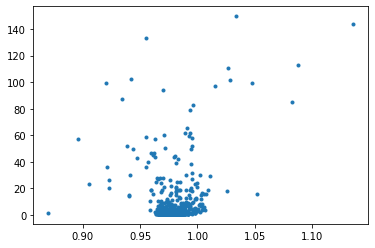

In [20]:
plt.plot(df.accTotal,df.gyrTotal,'.')
plt.show()

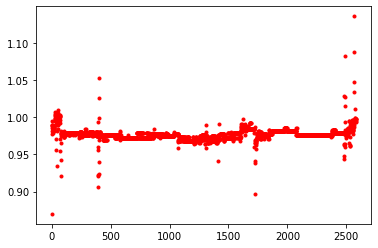

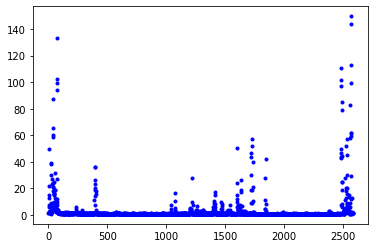

In [60]:
plt.plot(df.index,df.accTotal,'r.')
plt.show()
plt.plot(df.index,df.gyrTotal,'b.')
plt.show()



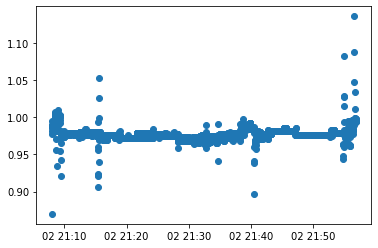

In [32]:
dates = matplotlib.dates.date2num(df.date.values)
plt.plot_date(dates, df.accTotal) #useful for later

# perhaps a box and whisker transformation to remove values that are below the median? They don't make much physical 
#sense.. how can you have an acceleration less than that of a still object?

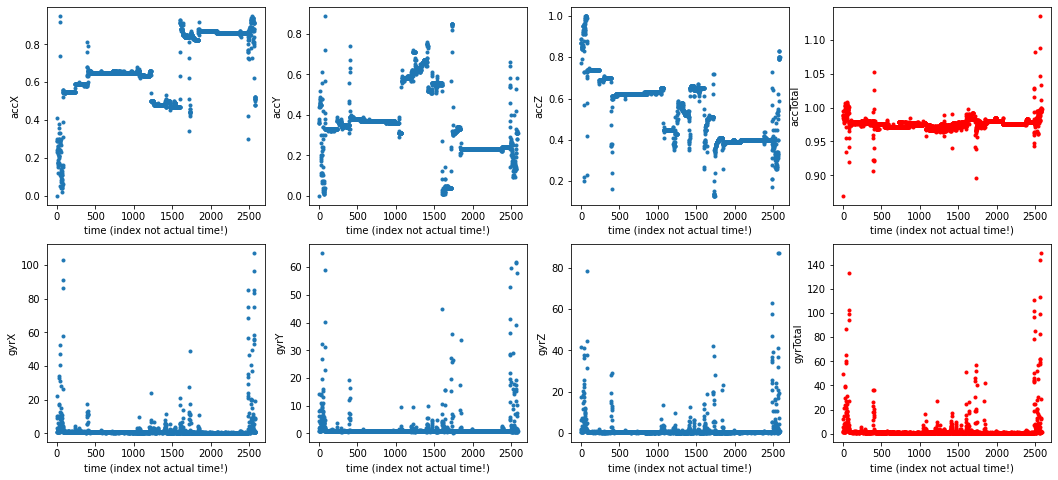

In [54]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'r.')
        else:
            plt.plot(df.index,df['{}{}'.format(parameter,plot)],'.')
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1
plt.show()

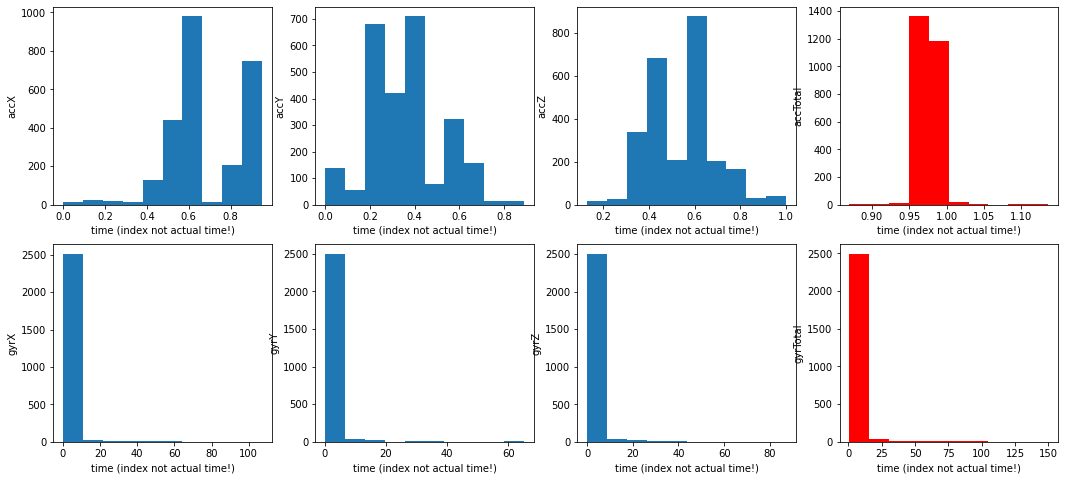

In [58]:
plots = ['X','Y','Z','Total']
plt.figure(figsize=(18,8))
i = 1
for parameter in ['acc','gyr']:
    for plot in plots:
        plt.subplot(int('24{}'.format(i)))
        if plot == 'Total':
            plt.hist(df['{}{}'.format(parameter,plot)],color = 'red')
        else:
            plt.hist(df['{}{}'.format(parameter,plot)])
        plt.ylabel('{}{}'.format(parameter,plot))
        plt.xlabel('time (index not actual time!)')
        i+=1

Based on the exploration done here, it would appear that the data is difficult to deal with. Here are some thoughts:

- the gyration vs. accleration graph does not show any nicely shaped clusters
- It might be worth determining whether gyration is in fact a parameter worthy of consideration for this exercise: does it really say much about whether the movement is significant? (Rohan)
- None of the graphs (time series) show 'clear' clusters
- The data is very much skewed: gyrations are mostly zero, and accelerations are centred around 0.96 (as this would appear to be 'stationary'). It is likely that a person spends most of their day sitting, so the data points for 'significant movement' will be low; the clustering technique used must account for this (perhaps using an outlier detection algorithm is best?)
- It's worth noting that total acceleration should not have a 'normal distribution', since you cannot have accelerations lower than that of about 1 g (since that is 'stationary'). As such, it might be worth filtering the lower end of the data when it comes to this (this would lead to a right skewed histogram, which **could** be fixed by a log transform)

# Data Exploration / Visualization Part II

In [70]:
median = df.accTotal.median()
iqr = df.accTotal.quantile(0.75) -df.accTotal.quantile(0.25)

df2 = df.copy()
df2 = df2[df2.accTotal >= median-iqr]
df2.shape

(2319, 10)

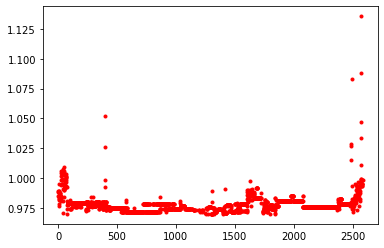

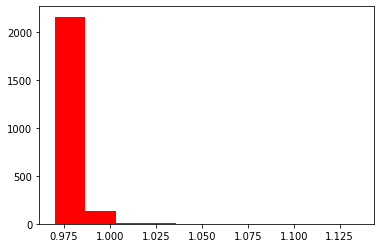

In [75]:
plt.plot(df2.index,df2.accTotal,'r.')
plt.show()

plt.hist(df2.accTotal,color = 'r')
plt.show()
#appears to be more 'normal'

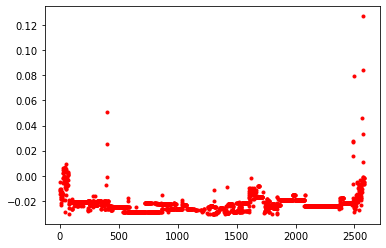

In [93]:
# transform to de-skew the data?
plt.plot(df2.index,np.log(df2.accTotal),'r.')
plt.show()
#de-skewing using a log transform does not seems to achieve any results

# Modelling attempt using DBSCAN

In [113]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(np.asarray(df2.accTotal).reshape(-1,1))
model = DBSCAN().fit(X)
model.labels_
true_false = []
for item in model.labels_:
    if item == 0:
        true_false.append(False)
    else:
        true_false.append(True)
        
anomalies = df2.accTotal[true_false]
actuals = df2.accTotal[[not i for i in true_false]]

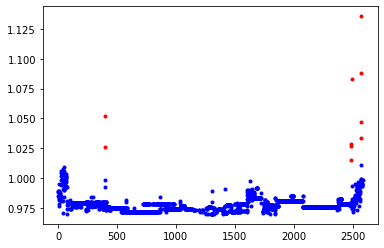

In [115]:
plt.plot(anomalies.index,anomalies,'r.')
plt.plot(actuals.index,actuals,'b.')